In [9]:
import torch, os, math
from math import sqrt
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [10]:
from torchvision.datasets import MNIST
from torchvision import transforms
tf = transforms.Compose([transforms.ToTensor()])
data = MNIST("/media/volume/sdb/data", train=False, download=False, transform=tf)
print(len(data))
print(data[0][0].shape)
images, labels = zip(*[data[i] for i in range(32)])
images = np.array(images)
print(images.shape)

10000
torch.Size([1, 28, 28])
(32, 1, 28, 28)


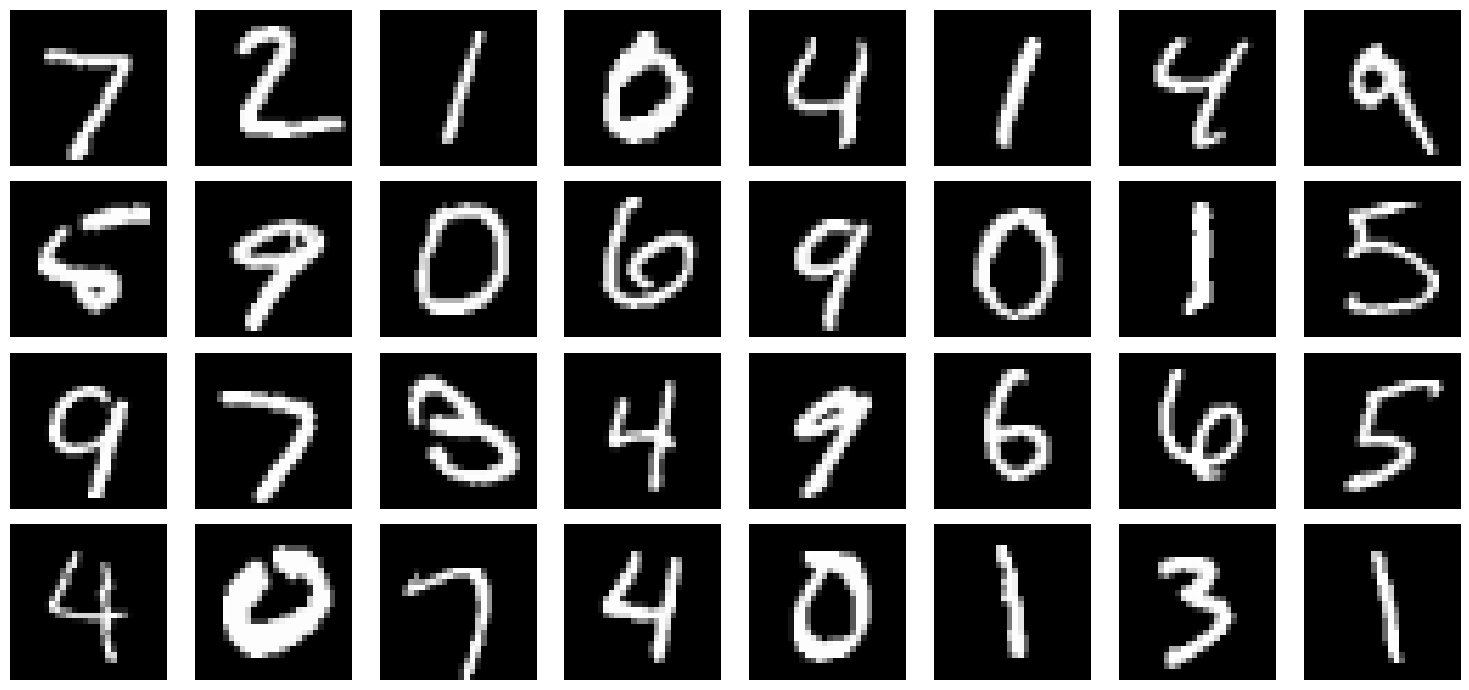

In [11]:
# Set up the plot
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(15, 7))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i in range(32):
    # Display image
    axes[i].imshow(images[i].squeeze(), cmap='gray')

    # Remove axis ticks
    axes[i].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

# Forward Diffusion Process

In [12]:
P_mean = -1.2
P_std = 1.2

def noise_distribution(data):
    return np.exp((P_mean + P_std * np.random.randn(data.shape[0])))

sigmas = noise_distribution(images)
print(sigmas.shape)
sigmas = rearrange(sigmas, 'b -> b 1 1 1')
print(sigmas.shape)
print(sigmas.squeeze())

(32,)
(32, 1, 1, 1)
[2.3442104  0.56424766 0.12608509 0.11274994 0.20308288 0.34614745
 1.33026711 1.34099697 0.03365349 0.40411631 0.28890352 0.16652814
 0.58147425 0.96129834 0.25739018 4.59603025 0.63540757 0.36245316
 0.06821495 0.57571634 1.21784206 0.0425036  0.1465701  0.49143961
 0.20264709 0.35468669 0.95453414 0.10431048 0.03272166 0.49524384
 0.38045184 0.08407637]


In [13]:
def forward_diffusion_process(data, sigmas):
    eps = np.random.randn(32, 1, 28, 28)
    delta = sigmas * eps
    data_t = data + delta
    return data_t, delta

x_t, delta = forward_diffusion_process(images, sigmas)
print(x_t.shape)
print(delta.shape)


(32, 1, 28, 28)
(32, 1, 28, 28)


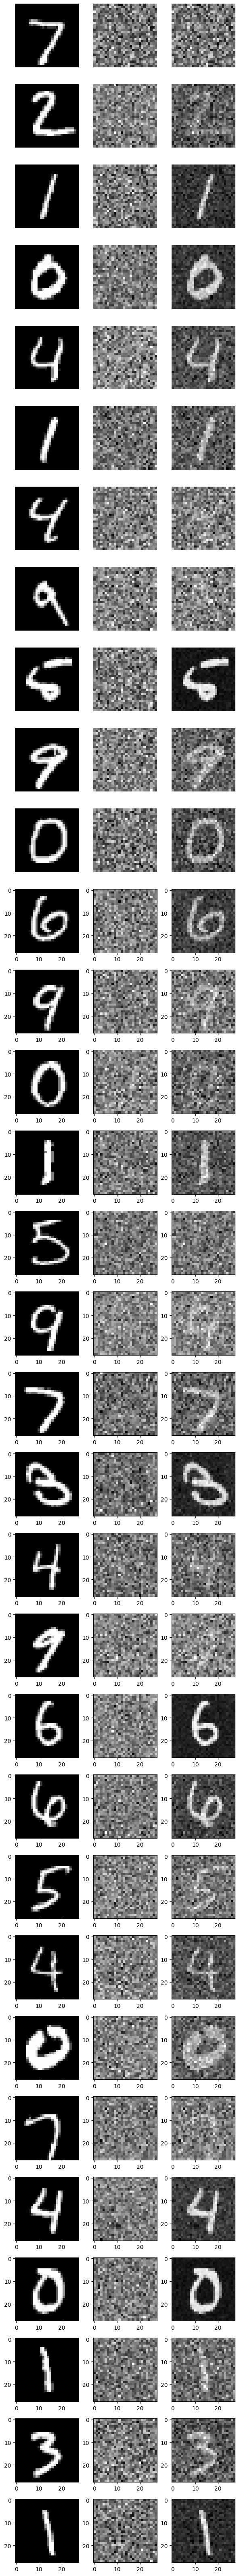

In [14]:
# Set up the plot
fig, axes = plt.subplots(nrows=32, ncols=3, figsize=(3*2, 32*2))

# Flatten the axes array for easy iteration
axes = axes.flatten()

j = 0
for i in range(32):
    # Display image
    axes[j].imshow(images[i].squeeze(), cmap='gray')
    axes[j+1].imshow(delta[i].squeeze(), cmap='gray')
    axes[j+2].imshow(x_t[i].squeeze(), cmap='gray')
    j += 3

    # Remove axis ticks
    axes[i].axis('off')
    axes[i+1].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

# Plotting the loss weighting function

In [15]:
# first we need to compute the sigma_data variable which is just the std of our dataset
sigma_data = np.std(images.flatten())
print('sigma_data = ', sigma_data)
def loss_weight(sigmas):
    return (sigmas ** 2 + sigma_data ** 2) * (sigmas * sigma_data) ** -2

loss_weights = loss_weight(sigmas)
print(loss_weights.shape)
print(loss_weights.squeeze())
print(sigmas.squeeze())

sigma_data =  0.2935885
(32, 1, 1, 1)
[ 11.7836815   14.74265457  74.50487806  90.26413414  35.84844957
  19.94769592  12.16680464  12.15779769 894.55906358  17.7250327
  23.58274333  47.6616251   14.55930579  12.68384898  26.69611563
  11.64904921  14.07853304  19.21366356 226.50391444  14.61876121
  12.27595407 565.14116537  58.15058515  15.74227427  35.9528469
  19.55066666  12.69924025 103.50775435 945.56416522  15.67890694
  18.51047686 153.06772694]
[2.3442104  0.56424766 0.12608509 0.11274994 0.20308288 0.34614745
 1.33026711 1.34099697 0.03365349 0.40411631 0.28890352 0.16652814
 0.58147425 0.96129834 0.25739018 4.59603025 0.63540757 0.36245316
 0.06821495 0.57571634 1.21784206 0.0425036  0.1465701  0.49143961
 0.20264709 0.35468669 0.95453414 0.10431048 0.03272166 0.49524384
 0.38045184 0.08407637]


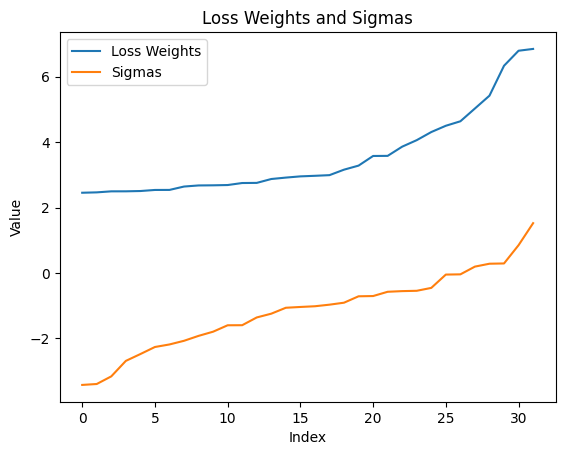

In [16]:
plt.figure()
plt.plot(np.log(np.sort(loss_weights.squeeze())), label='Loss Weights')
plt.plot(np.log(np.sort(sigmas.squeeze())), label='Sigmas')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Loss Weights and Sigmas')
plt.legend()
plt.show()

So I think everything is the same, except how we define the target value? In EDM you just try to reconstruct the original image, x_0. In consistency models you are trying to predict x_t_minus_1 ie learning the ode trajectory. So they propse to use the euler solver to get an unbiased estimate of x_t_minus_1. 

In [26]:
rho = 7
sigma_min = 0.002
sigma_max = 80
def sample_schedule():
    inv_rho = 1 / rho
    steps = np.random.randint(0, 50 - 1, (32))
    t = (sigma_max ** inv_rho + steps / (50 - 1) 
              * (sigma_min ** inv_rho - sigma_max ** inv_rho)) ** rho
    t = rearrange(t, 'b -> b 1 1 1')
    t_minus_1 = (sigma_max ** inv_rho + (steps + 1) / (50 - 1) 
              * (sigma_min ** inv_rho - sigma_max ** inv_rho)) ** rho
    t_minus_1 = rearrange(t_minus_1, 'b -> b 1 1 1')
    return t, t_minus_1

def euler_solver(x_t, t, t_minus_1, x_0): 
    # remember \sigma(t) = t in EDM so t and tm1 are actually sigma values
    d = (x_t - x_0) / t
    dt = t_minus_1 - t
    x_t_minus_1 = x_t + d * dt
    return x_t_minus_1

sigma_t, sigma_t_minus_1 = sample_schedule()
x_t, delta = forward_diffusion_process(images, sigma_t)
x_t_minus_1 = euler_solver(x_t, sigma_t, sigma_t_minus_1, images)
print(x_t.shape)
print(delta.shape)
print(x_t_minus_1.shape)

(32, 1, 28, 28)
(32, 1, 28, 28)
(32, 1, 28, 28)


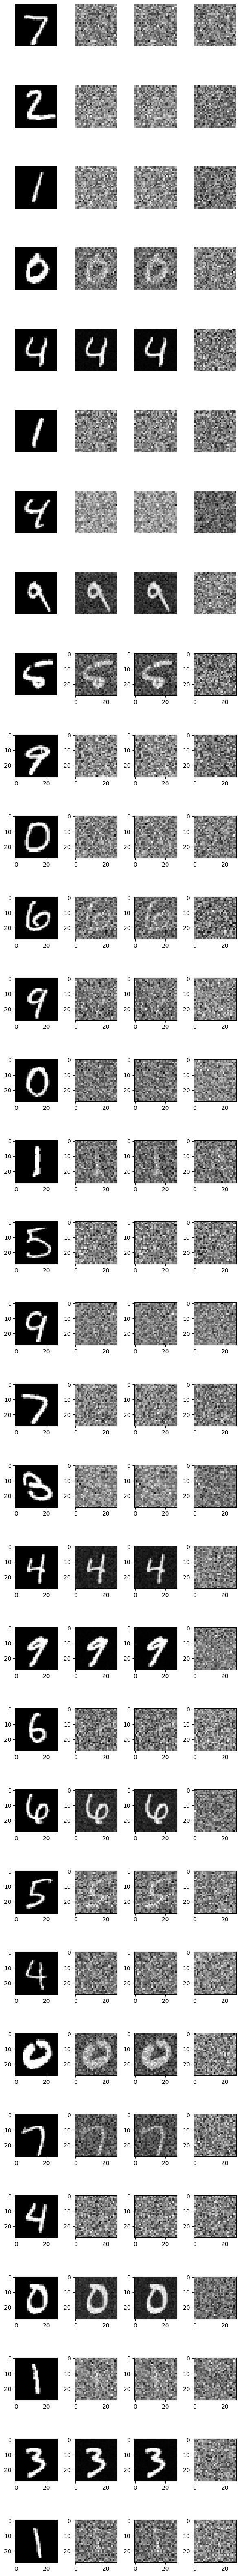

In [28]:
# Set up the plot
fig, axes = plt.subplots(nrows=32, ncols=4, figsize=(3*2, 32*2))

# Flatten the axes array for easy iteration
axes = axes.flatten()

j = 0
for i in range(32):
    # Display image
    axes[j].imshow(images[i].squeeze(), cmap='gray')
    axes[j+1].imshow(x_t[i].squeeze(), cmap='gray')
    axes[j+2].imshow(x_t_minus_1[i].squeeze(), cmap='gray')
    axes[j+3].imshow((x_t_minus_1[i] - x_t[i]).squeeze(), cmap='gray')
    j += 4

    # Remove axis ticks
    axes[i].axis('off')
    axes[i+1].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()